Import model data for comparison with observations

In [1]:
import netCDF4 as nc
import datetime as dt
import pandas as pd
from pandas import Series, DataFrame
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import glob
import dateutil as dutil
from salishsea_tools import viz_tools, places
import xarray as xr
from salishsea_tools import evaltools as et
from collections import OrderedDict

%matplotlib inline

In [2]:

start_date = dt.datetime(2010,1,1)
end_date = dt.datetime(2011,12,31)
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
# filemap is dictionary of the form variableName: fileType, where variableName is the name
# of the variable you want to extract and fileType designates the type of 
# model output file it can be found in (usually ptrc_T for biology, grid_T for temperature and 
# salinity)
filemap={'PPDIAT':'prod_T','PPPHY':'prod_T'}
# fdict is a dictionary mappy file type to its time resolution. Here, 1 means hourly output
# (1h file) and 24 means daily output (1d file). In certain runs, multiple time resolutions 
# are available
fdict={'prod_T':24,'grid_T':24} #24 for hours averaged 

In [3]:
filemap

{'PPDIAT': 'prod_T', 'PPPHY': 'prod_T'}

In [4]:
#f=nc.Dataset('/results2/SalishSea/nowcast-green.202111/26jul23/SalishSea_1d_20230726_20230726_prod_T.nc')

In [5]:
#f.variables.keys()

In [6]:
PATH= '/results2/SalishSea/nowcast-green.202111/'

In [7]:
df2=pd.read_csv('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/Evaluations/SaanichPrimaryProduction_DepthSpecific.csv')

In [8]:
df2

,Date,Z_lower,Z_upper,Lat,Lon,Primary Production (µmolC/L/h)
0,11-Mar-10,0,0,48.59,-123.51,0.04
1,11-Mar-10,2,2,48.59,-123.51,0.10
2,11-Mar-10,8,8,48.59,-123.51,0.12
3,11-Mar-10,18,18,48.59,-123.51,0.00
4,18-Mar-10,0,0,48.59,-123.51,0.18
...,...,...,...,...,...,...
99,04-Aug-11,17,17,48.59,-123.51,0.00
100,17-Aug-11,0,0,48.59,-123.51,0.92
101,17-Aug-11,2,2,48.59,-123.51,0.91
102,17-Aug-11,5,5,48.59,-123.51,1.11


In [9]:
df2.rename(columns={'Date':'dtUTC'}, inplace=True)

In [10]:
df2['dtUTC'][0]

'11-Mar-10'

In [11]:
df2['dtUTC'] = df2['dtUTC'].apply(lambda x:
    dt.datetime.strptime(x, '%d-%b-%y'))

In [12]:
df2['dtUTC']

0     2010-03-11
1     2010-03-11
2     2010-03-11
3     2010-03-11
4     2010-03-18
         ...    
99    2011-08-04
100   2011-08-17
101   2011-08-17
102   2011-08-17
103   2011-08-17
Name: dtUTC, Length: 104, dtype: datetime64[ns]

In [13]:
data=et.matchData(df2,filemap,fdict,start_date,end_date,namfmt,PATH,flen,quiet=False,method='vertNet');

ftype=prod_T, are you sure? (if yes, add to list)


In [14]:
data

,dtUTC,Z_lower,Z_upper,Lat,Lon,Primary Production (µmolC/L/h),j,i,mod_PPDIAT,mod_PPPHY,k_upper,k_lower
0,2010-03-11,0,0,48.59,-123.51,0.04,343,198,1.133342e-05,6.165959e-07,0,0
1,2010-03-11,2,2,48.59,-123.51,0.10,343,198,9.892851e-06,5.857280e-07,1,1
2,2010-03-11,8,8,48.59,-123.51,0.12,343,198,1.943511e-06,4.013070e-07,7,7
3,2010-03-11,18,18,48.59,-123.51,0.00,343,198,2.837013e-07,1.799787e-07,17,17
4,2010-03-18,0,0,48.59,-123.51,0.18,343,198,1.868914e-05,7.652120e-07,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99,2011-08-04,17,17,48.59,-123.51,0.00,343,198,2.251967e-07,1.157120e-06,16,16
100,2011-08-17,2,2,48.59,-123.51,0.91,343,198,3.789441e-07,2.305688e-05,1,1
101,2011-08-17,5,5,48.59,-123.51,1.11,343,198,9.680538e-06,5.003816e-06,4,4
102,2011-08-17,0,0,48.59,-123.51,0.92,343,198,2.171762e-07,2.275390e-05,0,0


In [15]:
data.keys()

Index(['dtUTC', 'Z_lower', 'Z_upper', 'Lat', 'Lon',
       'Primary Production (µmolC/L/h)', 'j', 'i', 'mod_PPDIAT', 'mod_PPPHY',
       'k_upper', 'k_lower'],
      dtype='object')

In [16]:
cm1=cmocean.cm.thermal
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [17]:
data.keys()

Index(['dtUTC', 'Z_lower', 'Z_upper', 'Lat', 'Lon',
       'Primary Production (µmolC/L/h)', 'j', 'i', 'mod_PPDIAT', 'mod_PPPHY',
       'k_upper', 'k_lower'],
      dtype='object')

In [18]:
data['mod_prod']=(data['mod_PPDIAT']+data['mod_PPPHY'])*86400*6.6*12/1000
## mmol N m-3 s-1 so multiply by 86400 to get d-1 and by C:N ratio of 6.6 to get mmol C and then by molecular weight of C to get mg C
## new units = g C m-3 d-1

In [19]:
data['mod_prod']

0      0.081773
1      0.071704
2      0.016045
3      0.003173
4      0.133124
         ...   
99     0.009459
100    0.160369
101    0.100483
102    0.157188
103    0.006371
Name: mod_prod, Length: 104, dtype: float64

In [20]:
data['mod_prod'].min()

0.0019360462615532015

In [21]:
data['mod_prod'].max()

0.5900668150765704

In [22]:
data['mod_prod'].mean()

0.1217291940998103

In [23]:
data['obs_prod']=((data['Primary Production (µmolC/L/h)']))*12*12/1000
# units are umol C L-1 h-1 OR mmol C m-3 h-1

## Multiply by 12 to get value per day (# daylight hours ~12) instead of per hour and then by 12 again to get mg C instead of mmol C
## New units = g C m-3 d-1

In [24]:
data['obs_prod']

0      0.00576
1      0.01440
2      0.01728
3      0.00000
4      0.02592
        ...   
99     0.00000
100    0.13104
101    0.15984
102    0.13248
103    0.00000
Name: obs_prod, Length: 104, dtype: float64

In [25]:
data=data.dropna()

In [26]:
print(data['obs_prod'].min())
print(data['obs_prod'].max())
print(data['obs_prod'].mean())


0.0
1.02384
0.10546615384615385


In [27]:
print(data['mod_prod'].min())
print(data['mod_prod'].max())
print(data['mod_prod'].mean())

0.0019360462615532015
0.5900668150765704
0.1217291940998103


In [28]:
def byDepth(ax,obsvar,modvar,lims):
    SI=et.varvarPlot(ax,data,obsvar,modvar,'Z_lower',(5,20),'z','m',('orange','darkturquoise','navy'))
    l=ax.legend(handles=SI)
    ax.set_xlabel('Log10 Observations (g C m$^{-3}$ d$^{-1}$)+0.001',fontsize=12)
    ax.set_ylabel('Log10 Model (g C m$^{-3}$ d$^{-1}$)+0.001',fontsize=12)
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SI,l

(0.0, 5.0)

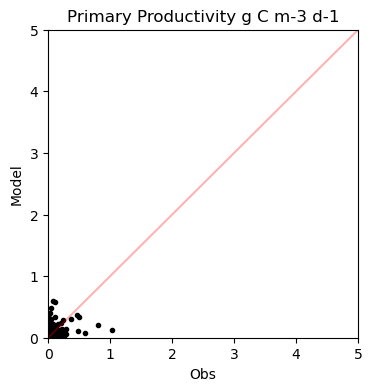

In [30]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
fig.subplots_adjust(hspace=1)
ax.plot(data['obs_prod'],data['mod_prod'],'k.')
ax.set_title('Primary Productivity g C m-3 d-1')
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.plot((0,40),(0,40),'r-',alpha=.3)
ax.set_xlim(0,5)
ax.set_ylim(0,5)

Text(0.5, 1.0, 'Primary Productivity By Depth')

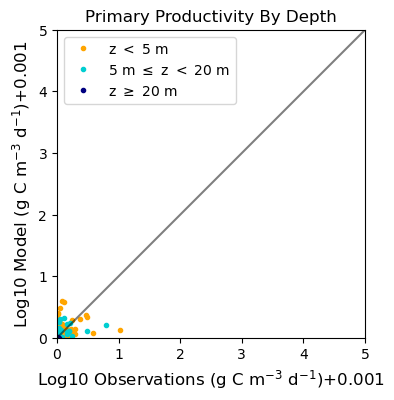

In [31]:
obsvar='obs_prod'
modvar='mod_prod'

fig, ax = plt.subplots(1,1,figsize = (4,4))
SI,l=byDepth(ax,obsvar,modvar,(0,5))
ax.set_title('Primary Productivity By Depth')

In [32]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
    return np.log10(x+.001)

In [33]:
data['L10Productivity']=logt(data['obs_prod'])
data['L10mod_prod']=logt(data['mod_prod'])

### Depth-specific Point by Point comparisions of model vs obs

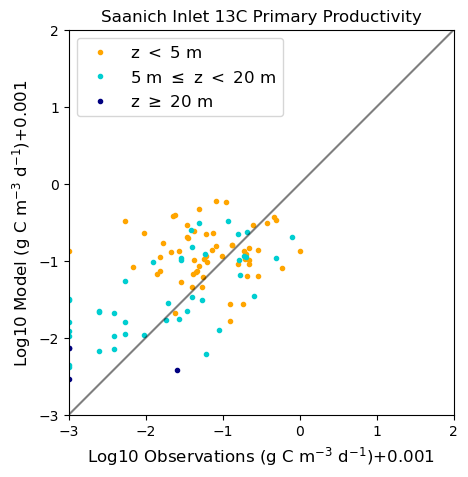

In [53]:
obsvar2='L10Productivity'
modvar2='L10mod_prod'

fig, ax = plt.subplots(1,1,figsize = (5,5))
SI,l=byDepth(ax,obsvar2,modvar2,(-3,2))
ax.set_title('Saanich Inlet 13C Primary Productivity',fontsize=12)
ax.legend(frameon=True,fontsize=12)
#fig.savefig('SaanichLog10ModelvsObsProductivity.jpg',bbox_inches='tight')

In [35]:
ratio_modPPvsobsPP=data['mod_prod'].mean()/data['obs_prod'].mean()

In [36]:
ratio_modPPvsobsPP

## Compared to mod_diat/obs_diat HPLC biomass of 2.86 and mod_flag/obs_flag HPLC biomass of 3.45

1.1542015107271264

In [40]:
data['Month'] = data['dtUTC'].dt.month

In [41]:
data['Month'].max()

8

In [42]:
#data['Month']=[ii.month for ii in data['dtUTC']]
DJF=data.loc[(data.Month==12)|(data.Month==1)|(data.Month==2)]
MAM=data.loc[(data.Month==3)|(data.Month==4)|(data.Month==5)]
JJA=data.loc[(data.Month==6)|(data.Month==7)|(data.Month==8)]
SON=data.loc[(data.Month==9)|(data.Month==10)|(data.Month==11)]

In [43]:
def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    SS=et.varvarPlot(ax[0],DJF,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Winter')
    SS=et.varvarPlot(ax[1],MAM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Spring')
    SS=et.varvarPlot(ax[2],JJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('Summer')
    SS=et.varvarPlot(ax[3],SON,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Autumn')
    return 

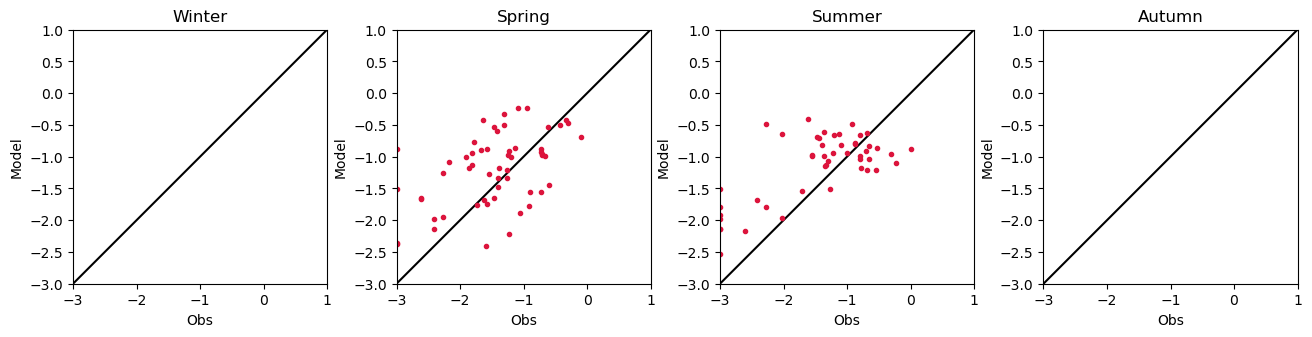

In [45]:
#fig, ax = plt.subplots(figsize = (5,4))     
#SS,l=byRegion(ax,'L10Productivity','L10mod_prod',(-2,4))
#ax.set_title('Primary Productivity By Region',fontsize=12)
#ax.legend(bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)
#fig.savefig('SalishSeaDIMicroZoopEval_byregion_noLegend.jpg',bbox_inches='tight')





fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Productivity','L10mod_prod',(-3,1))

In [49]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({
                      'All':data,
                      'Winter':DJF,
                      'Spring':MAM,
                      'Summer':JJA,
                      'Autumn': SON,})
#for iregion in data.Station.unique():
#statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['All', 'Winter', 'Spring', 'Summer', 'Autumn'])

In [50]:
# Defining variables needed for mesozooplankton evaluations
obsvar4='L10Productivity'
modvar4='L10mod_prod'
year=2023 #how do I calculate for all years?



In [51]:
statsDict={year:dict()}
statsDict[year]['MicroZ']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['MicroZ'][isub]=dict()
    var=statsDict[year]['MicroZ'][isub]
    var['N'],var['mmean'],var['omean'],var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar4]],
                                                                     statsubs[isub].loc[:,[modvar4]])
tbl,tdf=et.displayStats(statsDict[year]['MicroZ'],level='Subset',suborder=list(statsubs.keys()))
tbl

#tbl.to_excel("SalishSeaMicrozoopEvalStats.xlsx")

All
Winter
Spring
Summer
Autumn
